## Prepare Data

Prepare data for Train, Test, and Validation. Use them to try out different models.

In [1]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def get_rmse_score(model, X, y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    rmse = np.sqrt(mse)
    return rmse

def get_train_rmse(model, X, y):
    model.fit(X, y)
    pred = model.predict(X)
    return mean_squared_error(y, pred)

import pandas as pd

seed = 42
df_train = pd.read_csv("data/train_clean.csv")

Y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)

print(f"Data Shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_val.shape}")
print(f"Test:  {X_test.shape}")

Data Shapes:
Train: (1049, 280)
Valid: (117, 280)
Test:  (292, 280)


## Ridge and Lasso Linear Models

Original Feature Count: 280
Selected Feature Count: 144
Dropped 136 features.
          RIDGE VS LASSO PERFORMANCE
----------------------------------------
                   Model  Train RMSE  Valid RMSE  Test RMSE
                   Ridge    0.089258    0.117072   0.122281
                   Lasso    0.092478    0.114743   0.120141
Ridge (dropped features)    0.091380    0.114820   0.121616


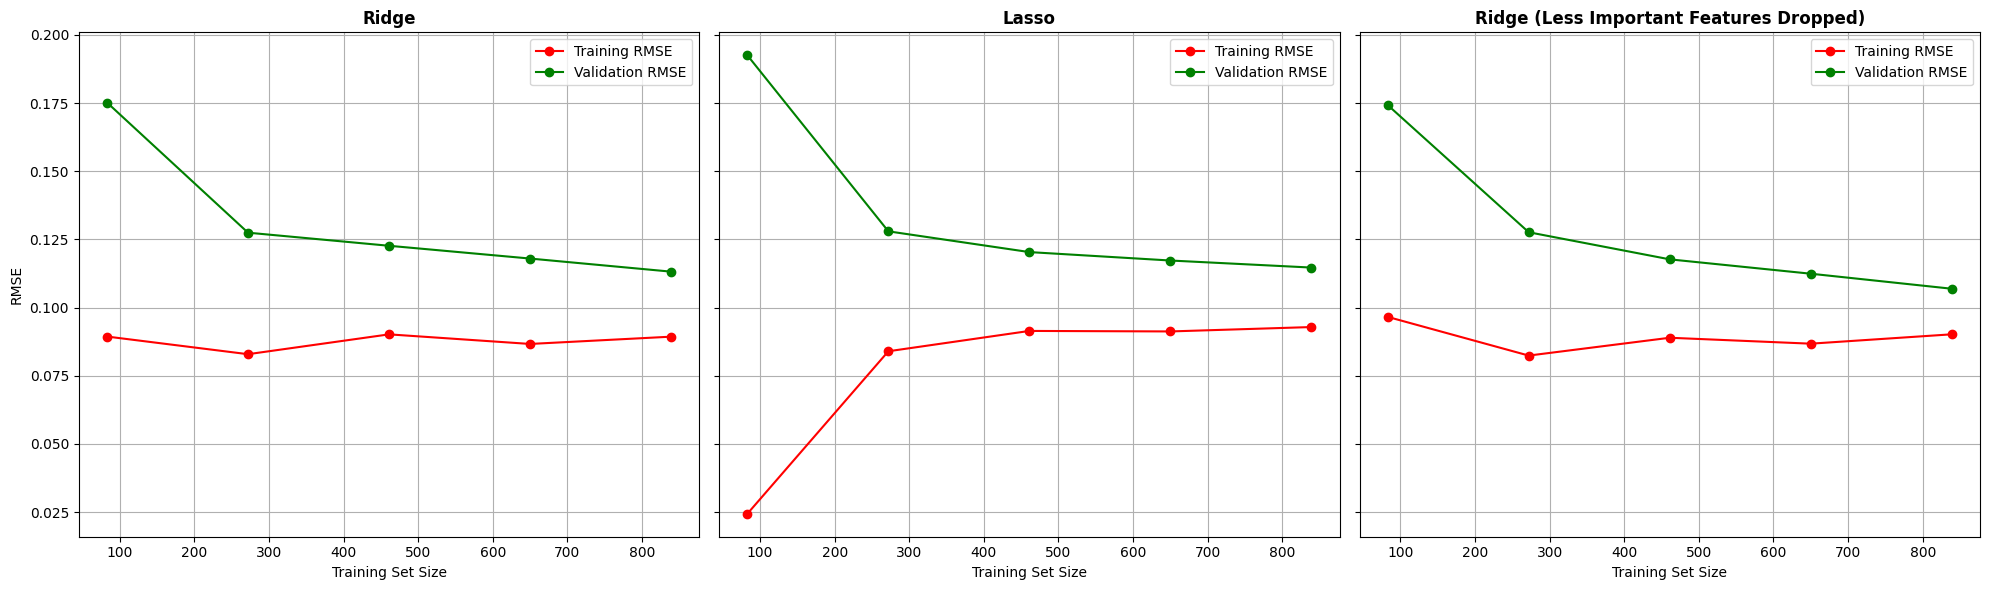

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

ridge_model = make_pipeline(
    RobustScaler(),
    RidgeCV(alphas=[0.1, 1, 5, 10, 20], cv=5)
)

lasso_model = make_pipeline(
    RobustScaler(),
    LassoCV(alphas=[0.0001, 0.0003, 0.0005, 0.001], cv=5, random_state=42)
)

ridge_model.fit(X_train, Y_train)
lasso_model.fit(X_train, Y_train)

# Here, slightly better performance in lasso regression means sparsity. what it means is that, setting some features to exactly zero BENIFITS the model.

lasso_estimator = lasso_model[-1] 
selected_mask = lasso_estimator.coef_ != 0
selected_features = X_train.columns[selected_mask]

print(f"Original Feature Count: {X_train.shape[1]}")
print(f"Selected Feature Count: {len(selected_features)}")
print(f"Dropped {X_train.shape[1] - len(selected_features)} features.")

unselected_features = X_train.columns[~selected_mask].tolist()

# now by dropping the unselected features, lets try again with ridge
X_train_dropped = X_train.drop(columns=unselected_features, axis=0)
X_val_dropped = X_val.drop(columns=unselected_features, axis=0)
X_test_dropped = X_test.drop(columns=unselected_features, axis=0)

ridge_model_dropped = make_pipeline(
    RobustScaler(),
    RidgeCV(alphas=[0.1, 1, 5, 10, 20], cv=5)
)

ridge_model_dropped.fit(X_train_dropped, Y_train)

def get_metrics(model, name, train, val, test):
    rmse_train = np.sqrt(mean_squared_error(Y_train, model.predict(train)))
    rmse_val   = np.sqrt(mean_squared_error(Y_val, model.predict(val)))
    rmse_test  = np.sqrt(mean_squared_error(Y_test, model.predict(test)))
    return [name, rmse_train, rmse_val, rmse_test]

results = []
results.append(get_metrics(ridge_model, "Ridge", X_train, X_val, X_test))
results.append(get_metrics(lasso_model, "Lasso", X_train, X_val, X_test))
results.append(get_metrics(ridge_model_dropped, "Ridge (dropped features)", X_train_dropped, X_val_dropped, X_test_dropped))

df_results = pd.DataFrame(results, columns=["Model", "Train RMSE", "Valid RMSE", "Test RMSE"])
print("          RIDGE VS LASSO PERFORMANCE")
print("-"*40)
print(df_results.to_string(index=False))

def plot_combined_learning_curves(models_info, y):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    
    for ax, (model, X, title) in zip(axes, models_info):
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=5, scoring='neg_mean_squared_error',
            train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=42
        )

        train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
        val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))
        ax.plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
        ax.plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Training Set Size")
        ax.grid(True)

        if ax == axes[0]:
            ax.set_ylabel("RMSE")
        else:
            ax.tick_params(labelleft=False)
            
        ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

models_to_plot = [
    (ridge_model, X_train, "Ridge"),
    (lasso_model, X_train, "Lasso"),
    (ridge_model_dropped, X_train_dropped, "Ridge (Less Important Features Dropped)")
]

plot_combined_learning_curves(models_to_plot, Y_train)

## XGBoost (Without and With Regularization)


XGBoost (No Regularization)
Train RMSE: 0.0047
Valid RMSE: 0.1468
Test  RMSE: 0.1478

XGBoost (With Regularization)
Train RMSE: 0.0397
Valid RMSE: 0.1224
Test  RMSE: 0.1210


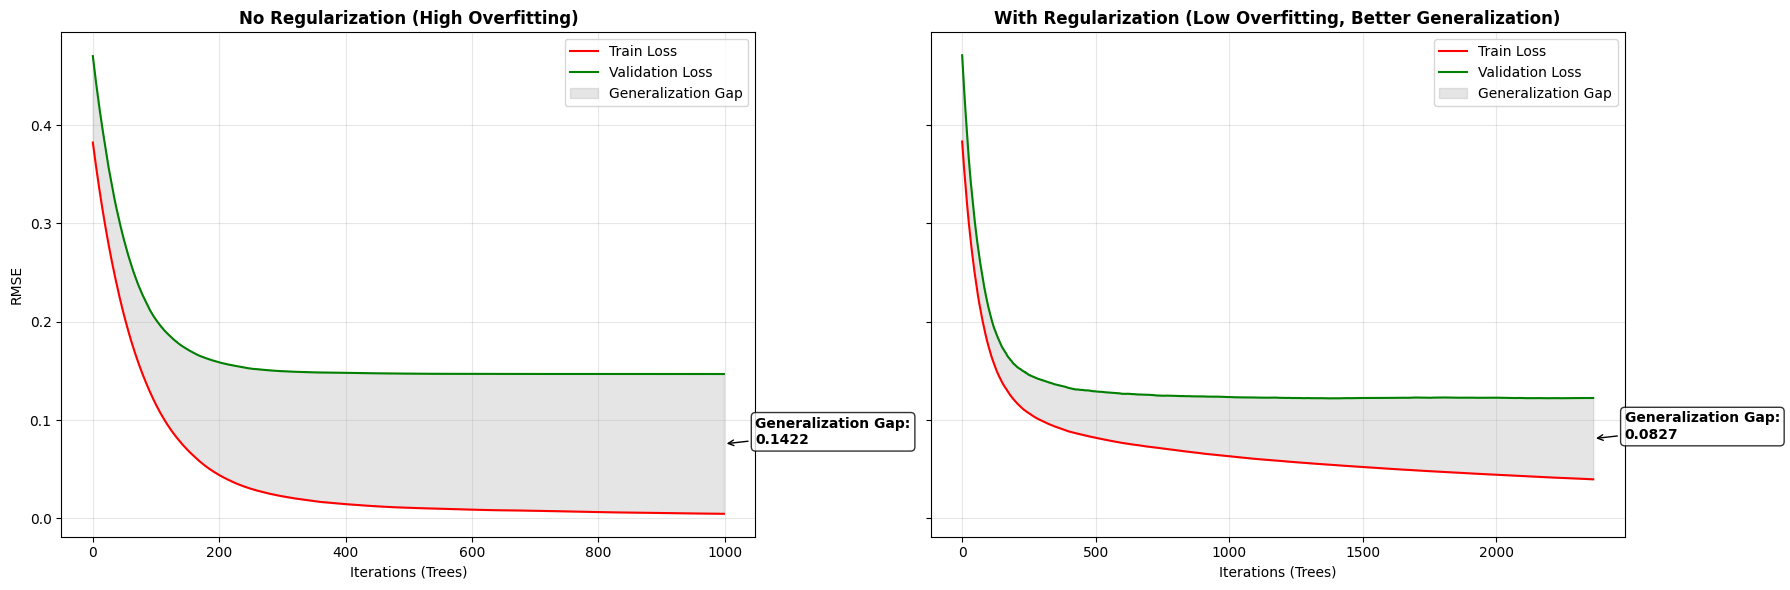

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb_unreg = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.015, 
    max_depth=8, 
    n_jobs=-1,
    random_state=seed,
)

xgb_unreg.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

xgb_reg = XGBRegressor(
    n_estimators=2365, 
    learning_rate=0.015, 
    max_depth=3, 
    n_jobs=-1,
    random_state=seed,
    reg_alpha=0.02,         # L1 (Lasso)
    reg_lambda=3e-05,       # L2 (Ridge)
    subsample=0.6,          # Row subsampling
    colsample_bytree=0.7,   # Feature subsampling
)

xgb_reg.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_val, Y_val)],
    verbose=False
)

def print_metrics(model, name, X_tr, Y_tr, X_v, Y_v, X_te, Y_te):
    pred_train = model.predict(X_tr)
    pred_val   = model.predict(X_v)
    pred_test  = model.predict(X_te)

    rmse_train = np.sqrt(mean_squared_error(Y_tr, pred_train))
    rmse_val   = np.sqrt(mean_squared_error(Y_v, pred_val))
    rmse_test  = np.sqrt(mean_squared_error(Y_te, pred_test))
    
    print(f"\n{name}")
    print("="*40)
    print(f"Train RMSE: {rmse_train:.4f}")
    print(f"Valid RMSE: {rmse_val:.4f}")
    print(f"Test  RMSE: {rmse_test:.4f}")

print_metrics(xgb_unreg, "XGBoost (No Regularization)", X_train, Y_train, X_val, Y_val, X_test, Y_test)
print_metrics(xgb_reg, "XGBoost (With Regularization)", X_train, Y_train, X_val, Y_val, X_test, Y_test)

def plot_combined_xgb_dynamics(models_data):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
    
    for ax, (model, title) in zip(axes, models_data):
        results = model.evals_result()
        train_rmse = np.array(results['validation_0']['rmse'])
        val_rmse = np.array(results['validation_1']['rmse'])
        epochs = len(train_rmse)
        x_axis = range(0, epochs)
        ax.plot(x_axis, train_rmse, label='Train Loss', color='red', linewidth=1.5)
        ax.plot(x_axis, val_rmse, label='Validation Loss', color='green', linewidth=1.5)
        ax.fill_between(x_axis, train_rmse, val_rmse, color='gray', alpha=0.2, label='Generalization Gap')
        final_gap = val_rmse[-1] - train_rmse[-1]
        final_x = x_axis[-1]
        final_y = (val_rmse[-1] + train_rmse[-1]) / 2
        
        ax.annotate(
            f'Generalization Gap:\n{final_gap:.4f}', 
            xy=(final_x, final_y), 
            xytext=(final_x + (epochs * 0.05), final_y),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8)
        )

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Iterations (Trees)')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        
        if ax == axes[0]:
            ax.set_ylabel('RMSE')
        
    plt.tight_layout()
    plt.show()

models_to_plot = [
    (xgb_unreg, "No Regularization (High Overfitting)"),
    (xgb_reg, "With Regularization (Low Overfitting, Better Generalization)")
]

plot_combined_xgb_dynamics(models_to_plot)

## Support Vector Machine

SVR PERFORMANCE
------------------------------
      Dataset        RMSE
     Training    0.129720
   Validation    0.164946
Test (Unseen)    0.194326

Total Training Samples: 1049
Number of Support Vectors: 953
Saturation Ratio: 90.85%
High saturation!


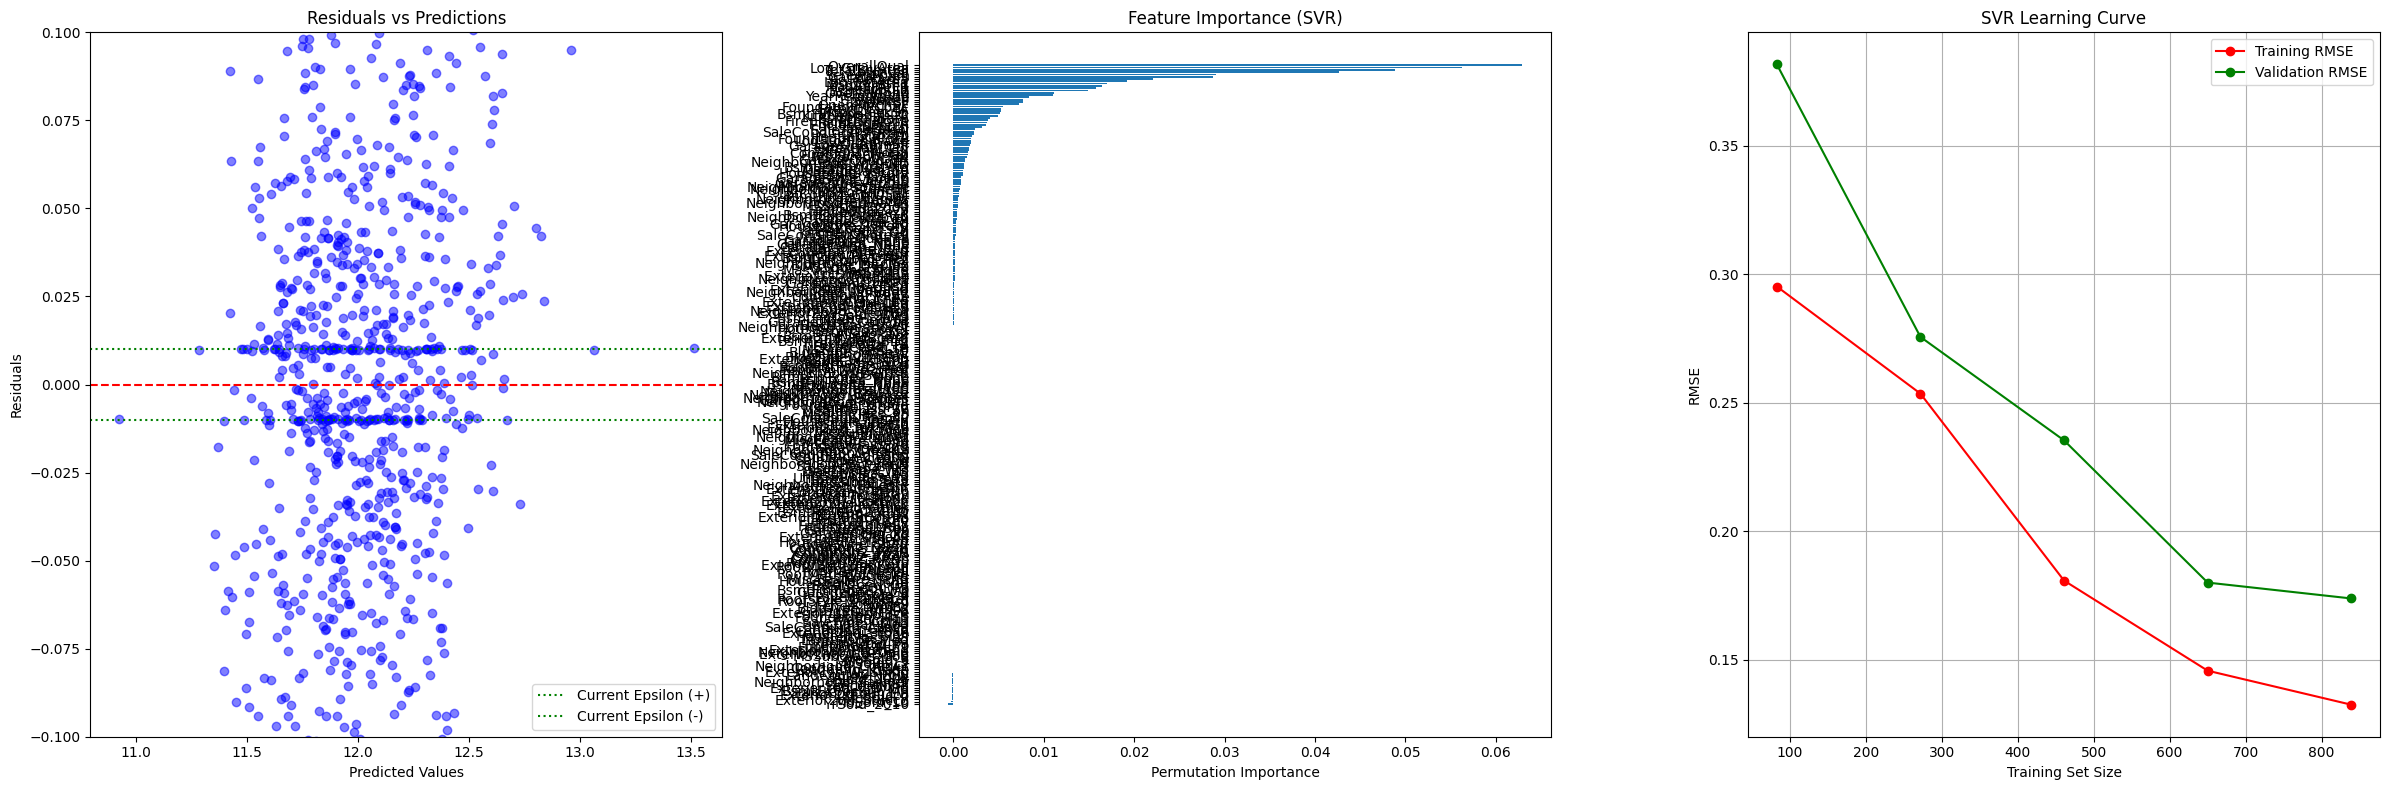

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance

svr_model = make_pipeline(
    RobustScaler(),
    SVR(C=100, epsilon=0.01, gamma='scale', kernel='rbf')
)
svr_model.fit(X_train, Y_train)

pred_train = svr_model.predict(X_train)
pred_val   = svr_model.predict(X_val)
pred_test  = svr_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset   ': ['Training   ', 'Validation   ', 'Test (Unseen)   '],
    'RMSE': [rmse_train, rmse_val, rmse_test]
})

print("SVR PERFORMANCE")
print("-"*30)
print(results_df.to_string(index=False))

svr_estimator = svr_model.named_steps['svr']
n_samples = X_train.shape[0]
n_support = svr_estimator.support_.shape[0]
saturation_ratio = n_support / n_samples

print(f"\nTotal Training Samples: {n_samples}")
print(f"Number of Support Vectors: {n_support}")
print(f"Saturation Ratio: {saturation_ratio:.2%}")

if saturation_ratio > 0.8:
    print("High saturation!")
elif saturation_ratio < 0.2:
    print("Model is sparse and efficient.")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

residuals = Y_train - pred_train
axes[0].scatter(pred_train, residuals, alpha=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].axhline(y=svr_estimator.epsilon, color='g', linestyle=':', label='Current Epsilon (+)')
axes[0].axhline(y=-svr_estimator.epsilon, color='g', linestyle=':', label='Current Epsilon (-)')
axes[0].set_ylim(-0.1, 0.1)
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Predictions")
axes[0].legend()

perm_importance = permutation_importance(svr_model, X_val, Y_val, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

axes[1].barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
axes[1].set_xlabel("Permutation Importance")
axes[1].set_title("Feature Importance (SVR)")

train_sizes, train_scores, val_scores = learning_curve(
    svr_model, X_train, Y_train, cv=5, 
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5), 
    n_jobs=-1, 
    random_state=42
)

train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

axes[2].plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
axes[2].plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
axes[2].set_title("SVR Learning Curve")
axes[2].set_xlabel("Training Set Size")
axes[2].set_ylabel("RMSE")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Dropped 265 features.
Remaining Features: 15

SVR PERFORMANCE (PRUNED)
------------------------------
      Dataset        RMSE
     Training    0.086853
   Validation    0.139468
Test (Unseen)    0.137365

Total Training Samples: 1049
Number of Support Vectors: 961
Saturation Ratio: 91.61%
High saturation!


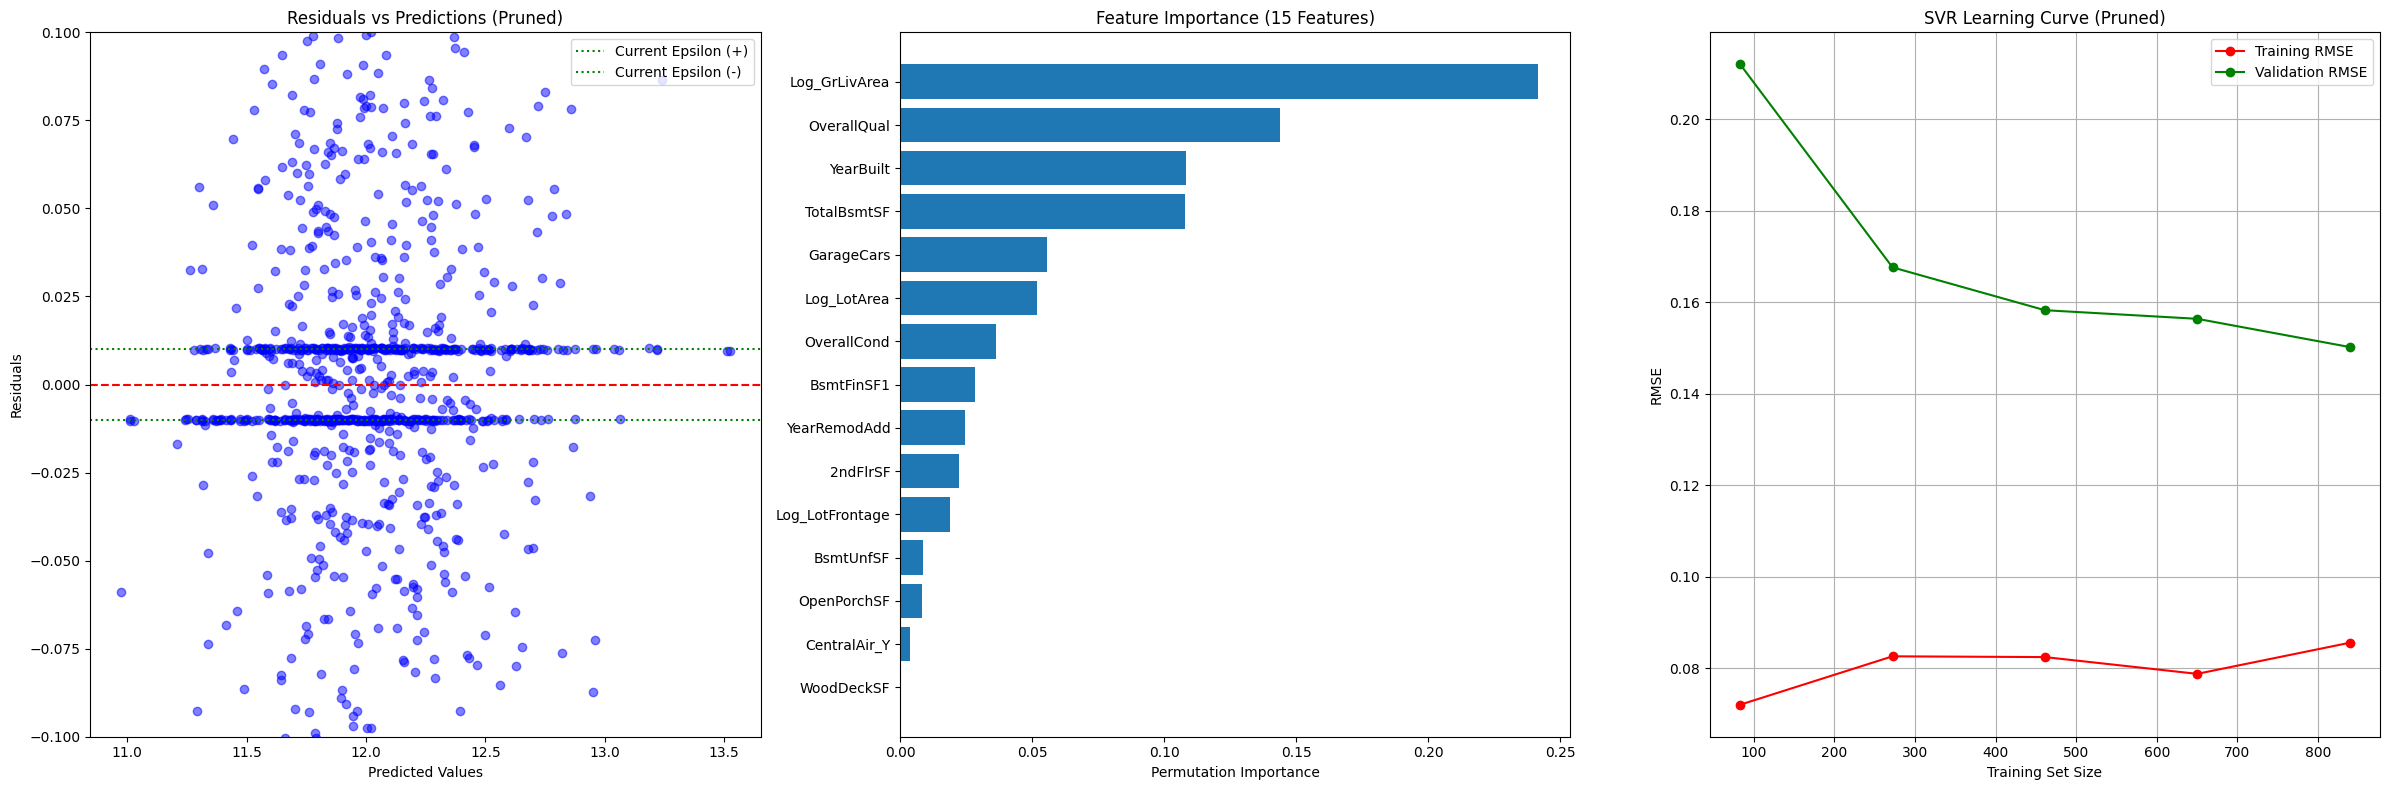

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
\
selector = SelectFromModel(
    RandomForestRegressor(n_estimators=100, random_state=42),
    threshold="1.25*mean"
)
selector.fit(X_train, Y_train)
selected_mask = selector.get_support()

X_train_pruned = X_train.loc[:, selected_mask]
X_val_pruned   = X_val.loc[:, selected_mask]
X_test_pruned  = X_test.loc[:, selected_mask]

print(f"Dropped {X_train.shape[1] - X_train_pruned.shape[1]} features.")
print(f"Remaining Features: {X_train_pruned.shape[1]}")

svr_model = make_pipeline(
    RobustScaler(),
    SVR(C=1, epsilon=0.01, gamma='scale', kernel='rbf')
)
svr_model.fit(X_train_pruned, Y_train)

pred_train = svr_model.predict(X_train_pruned)
pred_val   = svr_model.predict(X_val_pruned)
pred_test  = svr_model.predict(X_test_pruned)

rmse_train = np.sqrt(mean_squared_error(Y_train, pred_train))
rmse_val   = np.sqrt(mean_squared_error(Y_val, pred_val))
rmse_test  = np.sqrt(mean_squared_error(Y_test, pred_test))

results_df = pd.DataFrame({
    'Dataset   ': ['Training   ', 'Validation   ', 'Test (Unseen)   '],
    'RMSE': [rmse_train, rmse_val, rmse_test]
})

print("\nSVR PERFORMANCE (PRUNED)")
print("-"*30)
print(results_df.to_string(index=False))

svr_estimator = svr_model.named_steps['svr']
n_samples = X_train_pruned.shape[0]
n_support = svr_estimator.support_.shape[0]
saturation_ratio = n_support / n_samples

print(f"\nTotal Training Samples: {n_samples}")
print(f"Number of Support Vectors: {n_support}")
print(f"Saturation Ratio: {saturation_ratio:.2%}")

if saturation_ratio > 0.8:
    print("High saturation!")
elif saturation_ratio < 0.2:
    print("Model is sparse and efficient.")

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

residuals = Y_train - pred_train
axes[0].scatter(pred_train, residuals, alpha=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].axhline(y=svr_estimator.epsilon, color='g', linestyle=':', label='Current Epsilon (+)')
axes[0].axhline(y=-svr_estimator.epsilon, color='g', linestyle=':', label='Current Epsilon (-)')
# axes[0].set_yscale('log')
axes[0].set_ylim(-0.1, 0.1)
axes[0].set_xlabel("Predicted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Predictions (Pruned)")
axes[0].legend()

perm_importance = permutation_importance(svr_model, X_val_pruned, Y_val, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

axes[1].barh(X_train_pruned.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
axes[1].set_xlabel("Permutation Importance")
axes[1].set_title(f"Feature Importance ({len(X_train_pruned.columns)} Features)")

train_sizes, train_scores, val_scores = learning_curve(
    svr_model, X_train_pruned, Y_train, cv=5, 
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5), 
    n_jobs=-1, 
    random_state=42
)

train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))

axes[2].plot(train_sizes, train_rmse_mean, 'o-', color="r", label="Training RMSE")
axes[2].plot(train_sizes, val_rmse_mean, 'o-', color="g", label="Validation RMSE")
axes[2].set_title("SVR Learning Curve (Pruned)")
axes[2].set_xlabel("Training Set Size")
axes[2].set_ylabel("RMSE")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Neural Nets

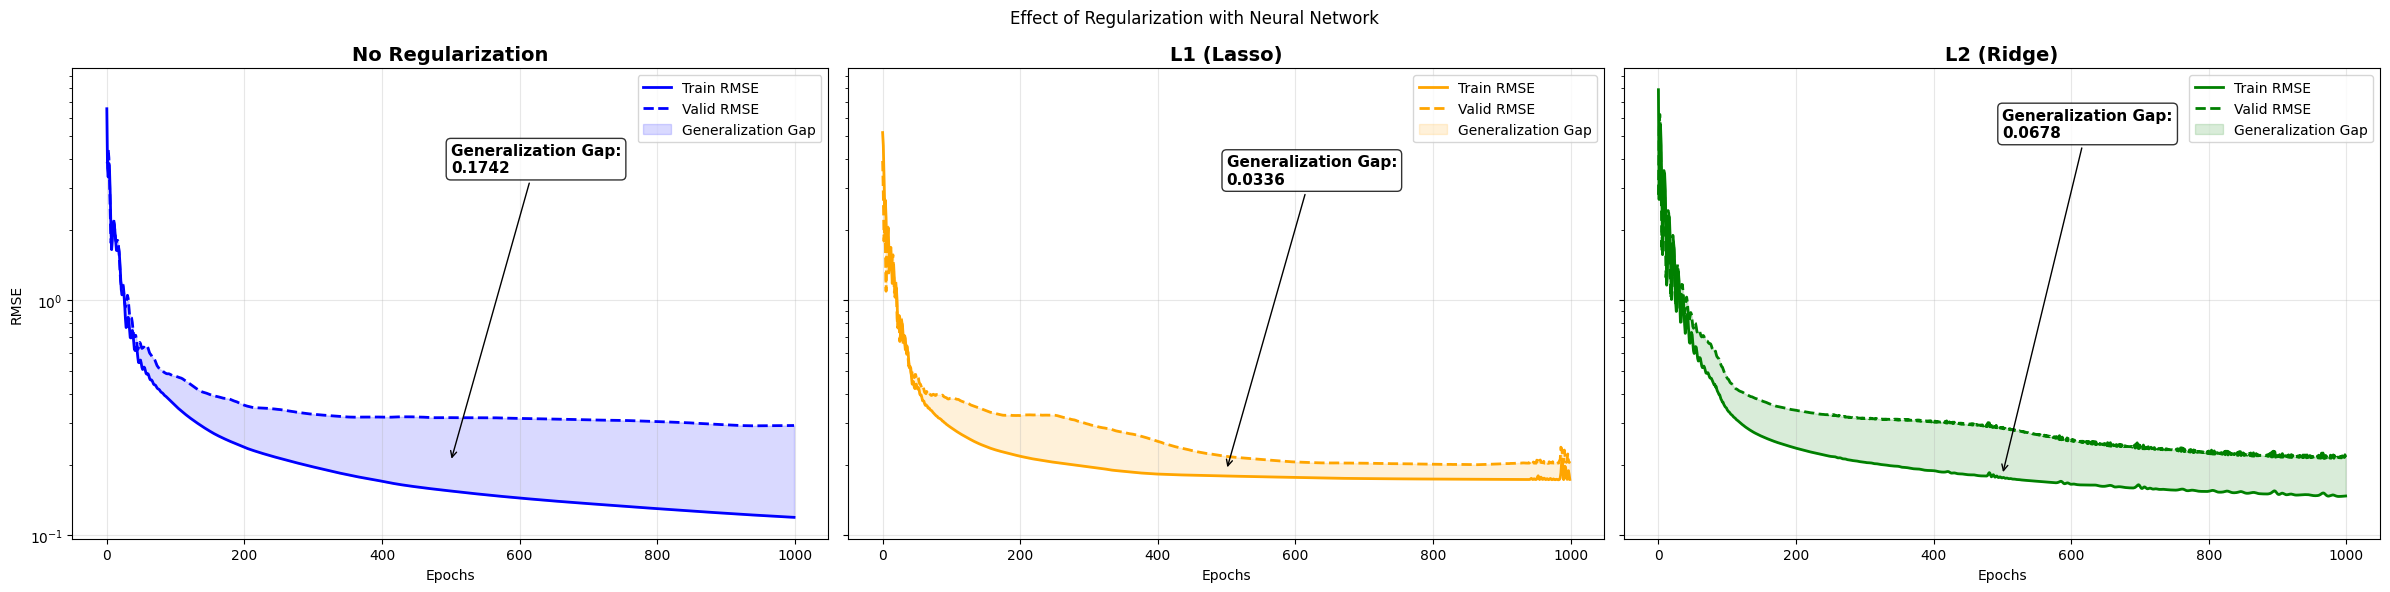


NEURAL NETWORK PERFORMANCE SUMMARY
--------------------------------------------------
           Method  Train RMSE  Valid RMSE  Test RMSE
No Regularization      0.1192      0.2935     0.2238
       L1 (Lasso)      0.1747      0.2065     0.2064
       L2 (Ridge)      0.1471      0.2148     0.2299
--------------------------------------------------


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0).astype('float32')

X_train_t = torch.FloatTensor(X_train.values)
y_train_t = torch.FloatTensor(Y_train.values).view(-1, 1)

X_val_t   = torch.FloatTensor(X_val.values)
y_val_t   = torch.FloatTensor(Y_val.values).view(-1, 1)

X_test_t  = torch.FloatTensor(X_test.values)
y_test_t  = torch.FloatTensor(Y_test.values).view(-1, 1)

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

def train_model(reg_type='none', reg_strength=0.0, epochs=500, lr=0.01):
    model = Model(X_train_t.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        predictions = model(X_train_t)
        base_loss = criterion(predictions, y_train_t)

        reg_loss = 0
        if reg_type == 'l1':
            for param in model.parameters():
                reg_loss += torch.sum(torch.abs(param))
        elif reg_type == 'l2':
            for param in model.parameters():
                reg_loss += torch.sum(param ** 2)
        
        total_loss = base_loss + (reg_strength * reg_loss)
        total_loss.backward()
        optimizer.step()

        train_rmse = torch.sqrt(base_loss).item()
        train_loss_history.append(train_rmse)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_rmse = torch.sqrt(criterion(val_pred, y_val_t)).item()
            val_loss_history.append(val_rmse)

    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t)
        test_pred = model(X_test_t)
        
        final_train_rmse = np.sqrt(mean_squared_error(y_train_t, train_pred))
        final_val_rmse = val_loss_history[-1]
        final_test_rmse = np.sqrt(mean_squared_error(y_test_t, test_pred))
    del model
    return train_loss_history, val_loss_history, final_train_rmse, final_val_rmse, final_test_rmse

epochs = 1000
lr = 0.001
lambda_reg = 0.01

t_hist_none, v_hist_none, train_none, val_none, test_none = train_model(
    reg_type='none', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l1, v_hist_l1, train_l1, val_l1, test_l1 = train_model(
    reg_type='l1', reg_strength=lambda_reg, epochs=epochs, lr=lr
)
t_hist_l2, v_hist_l2, train_l2, val_l2, test_l2 = train_model(
    reg_type='l2', reg_strength=lambda_reg, epochs=epochs, lr=lr
)

fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)

models_data = [
    ("No Regularization", t_hist_none, v_hist_none, 'blue'),
    ("L1 (Lasso)", t_hist_l1, v_hist_l1, 'orange'),
    ("L2 (Ridge)", t_hist_l2, v_hist_l2, 'green')
]

for ax, (title, t_hist, v_hist, color) in zip(axes, models_data):
    epochs_range = range(len(t_hist))
    ax.plot(epochs_range, t_hist, label='Train RMSE', color=color, linewidth=2)
    ax.plot(epochs_range, v_hist, label='Valid RMSE', color=color, linestyle='--', linewidth=2)
    ax.fill_between(epochs_range, t_hist, v_hist, color=color, alpha=0.15, label='Generalization Gap')
    final_gap = v_hist[-1] - t_hist[-1]
    
    ax.annotate(f'Generalization Gap:\n{abs(final_gap):.4f}', 
                xy=(epochs * 0.5, (v_hist[-1] + t_hist[-1])/2),
                xytext=(epochs * 0.5, max(v_hist)*0.8),
                arrowprops=dict(facecolor='black', arrowstyle='->'),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epochs')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_yscale('log')

axes[0].set_ylabel('RMSE')
plt.suptitle("Effect of Regularization with Neural Network")
plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'Method': ['No Regularization', 'L1 (Lasso)', 'L2 (Ridge)'],
    'Train RMSE': [train_none, train_l1, train_l2],
    'Valid RMSE': [val_none, val_l1, val_l2],
    'Test RMSE':  [test_none, test_l1, test_l2]
})

print("\nNEURAL NETWORK PERFORMANCE SUMMARY")
print("-" * 50)
print(results_df.round(4).to_string(index=False))
print("-" * 50)

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error',
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    # Convert negative MSE to RMSE
    train_scores_mean = np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Error")
    
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("RMSE (Log Scale)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Score: 0.74
Mean Squared Error: 0.04
Index(['OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', 'KitchenAbvGr', 'GarageCars', 'Log_LotArea',
       'Log_GrLivArea', 'CentralAir_Y'],
      dtype='object')


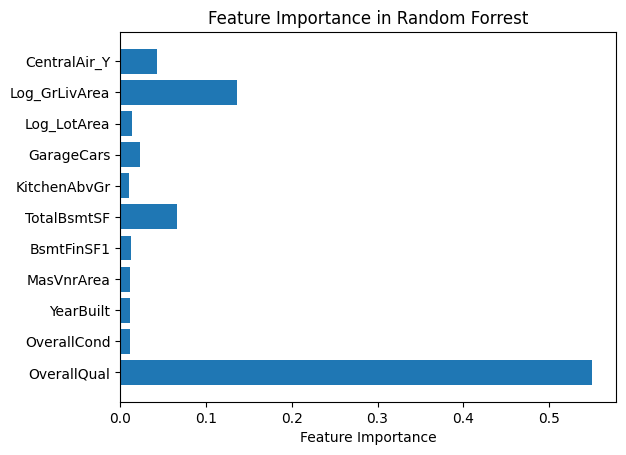

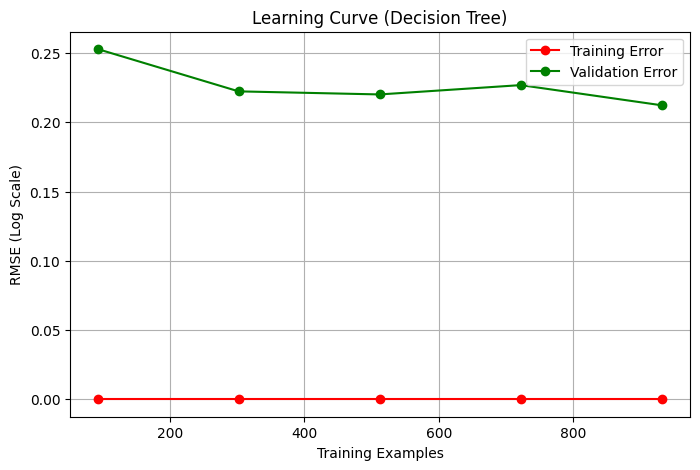

In [8]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split

seed = 42

# init decission tree classifier
clf = DecisionTreeRegressor(criterion="squared_error")

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

score = clf.score(X_test, Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(clf, "Learning Curve (Decision Tree)", X_train, Y_train)


Score: 0.88
Mean Squared Error: 0.02
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       'GarageCars', 'Log_LotArea', 'Log_GrLivArea', 'CentralAir_Y'],
      dtype='object')


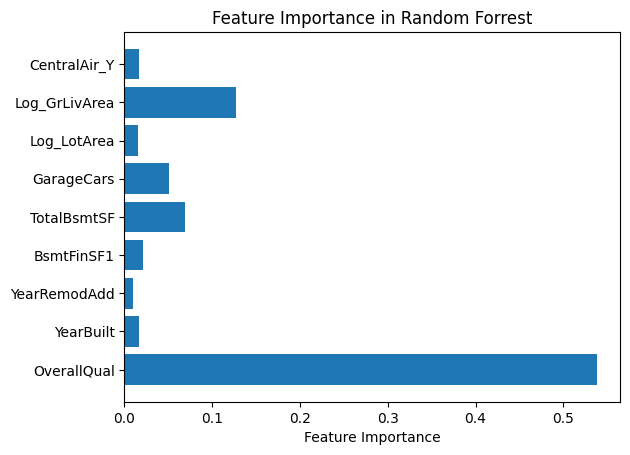

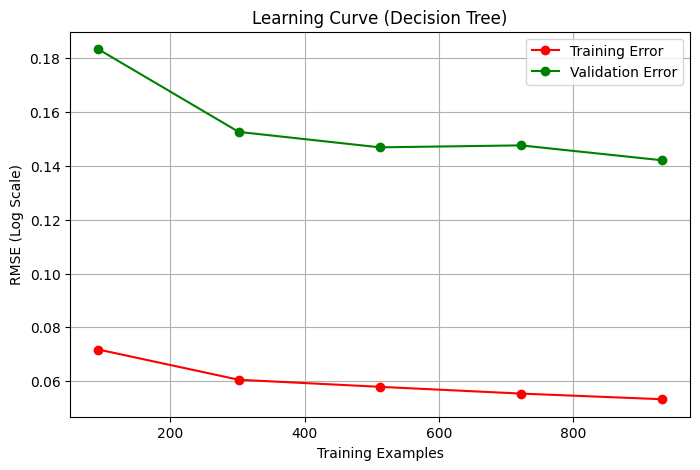

In [9]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

rf_clf = RandomForestRegressor(n_estimators=100, random_state=seed)

y = df_train['Log_SalePrice']
X = df_train.drop(columns=['Log_SalePrice'])

X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2, random_state=seed)

rf_clf.fit(X_train,Y_train)
Y_pred = rf_clf.predict(X_test)

score = rf_clf.score(X_test,Y_test)
print("Score: %.2f" % (score))

mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error: %.2f" % (mse))

feature_importances = rf_clf.feature_importances_

threshold = .01
important_features = X_train.columns[feature_importances > threshold]
print(important_features)

# plt.barh(X_train.columns, feature_importances)
plt.barh(important_features, [x for x in feature_importances if x > threshold])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forrest")
plt.show()

plot_learning_curve(rf_clf, "Learning Curve (Decision Tree)", X_train, Y_train)